In [1]:
from scipy.stats import truncnorm
import pandas as pd
import numpy as np
import itertools
import datetime
import tqdm
import sys
import os

def flatten_list(list_array):
    return list(itertools.chain(*list_array))

sys.path.insert(0, "../")
sys.path.insert(0,"../pompjax/pompjax/")

from global_config import config

results_dir           = config.get_property('results_dir')
results2_dir          = config.get_property('results2_dir')

data_dir              = config.get_property('data_dir')
paper_dir             = config.get_property('paper_dir')
data_db_dir           = config.get_property('data_db_dir')
feb_hosp_records_path = os.path.join(data_db_dir, 'long_files_8_25_2021')
path_to_save          = os.path.join(results_dir, "real_testing", "community")

COLOR_LIST1           = ["#F8AFA8", "#FDDDA0", "#F5CDB4", "#74A089"]

from abm_utils import empirical_prevalence, simulate_abm, create_obs_infer
from utils_local.misc import amro2title, amro2cute


In [2]:
from diagnostic_plots import convergence_plot
from abm_utils import run_amro_synthetic
from utils import create_df_response
from ifeakf import ifeakf

amro_search  = ['ESCHERICHIA COLI', 'KLEBSIELLA PNEUMONIAE',  'PSEUDOMONAS AERUGINOSA',
                'METHICILLIN-SUSCEPTIBLE STAPHYLOCOCCUS AUREUS', 'METHICILLIN-RESISTANT STAPHYLOCOCCUS AUREUS',
                "STAPHYLOCOCCUS EPIDERMIDIS", 'ENTEROCOCCUS FAECALIS', 'ENTEROCOCCUS FAECIUM']


In [3]:
def mahalanobis_distance(u, v, cov_u):
    """ Mahalanobis distance between a distribution θhat and a point θtruth

    Args:
        u:     Mean of distribution U
        v:     Point
        cov_u: Covariance matrix of U

    Returns:
        _type_: _description_
    """
    return np.sqrt((v - u).T @ np.linalg.inv(cov_u) @ (v - u))

def lin_reg(x, y):
    y    = np.expand_dims(y, -1)
    xreg = np.float64(np.concatenate([np.expand_dims(x, -1), np.ones_like(y)], axis=1))
    p    = np.linalg.inv(xreg.T @ xreg) @ xreg.T @ y
    x    = np.expand_dims(np.linspace(np.around(np.min(x),1), np.max(x), 100), -1)
    x    = np.float64(np.concatenate([x, np.ones_like(x)], axis=1)).T

    yhat = np.squeeze(p.T @ x)

    return x[0,:], yhat


In [4]:
from pyro.contrib.forecast import eval_crps
import torch

if_settings = {
        "Nif"                : 30,          # number of iterations of the IF
        "type_cooling"       : "geometric", # type of cooling schedule
        "shrinkage_factor"   : 0.9,         # shrinkage factor for the cooling schedule
        "inflation"          : 1.01         # inflation factor for spreading the variance after the EAKF step
        }

dates_simulation = pd.date_range(start=pd.to_datetime("2020-02-01"), end=pd.to_datetime("2021-02-28"), freq="D")

model_settings   = {
                    "m"                 : 200,
                    "p"                 : 2,
                    "n"                 : 120000,
                    "k"                 : 6,
                    "dates"             : pd.date_range(start="2020-02-01", end="2021-02-28", freq="D"),
                    "dates_simulation"  : pd.date_range(start="2020-02-01", end="2021-02-28", freq="D"),
                    "T"                 : len(dates_simulation),  # time to run
                    "num_build"         : 6,
                    "k"                 : 6# observing at the building aggregation
                }

assim_dates                       = list(pd.date_range(start=pd.to_datetime("2020-02-01"), end=pd.to_datetime("2021-02-28"), freq="W-Sun"))
assim_dates[-1]                   = dates_simulation[-1]
if_settings["assimilation_dates"] = assim_dates
id_run                            = 1

distance_df = pd.DataFrame()
for amro in amro_search:

    path_to_save = os.path.join(results2_dir, "synthetic_inferences", "abm", f"{amro2cute(amro)}")
    scenarios_df = pd.read_csv(os.path.join(path_to_save, "scenarios.csv"))
    gamma        = empirical_prevalence(amro, path_to_prev="../data/amro_prevalence.csv")

    for idx_row, row in scenarios_df.iterrows():
        path_to_samples = os.path.join(path_to_save, "infer_building", f"scenario{idx_row+1}")
        try:
                inference       = np.load(os.path.join(path_to_save, "infer_building", f"scenario{idx_row+1}", f"{str(id_run).zfill(3)}posterior.npz"))
        except:
             print("amro: {}, scenario: {}, run: {}".format(amro, idx_row+1, id_run))

        θpost  = inference["posterior"].mean(-2)[:, :, -1]
        θtruth = inference["teta_truth"][:, [0]] # [p, 1], Truth (vector column)
        ysim   = inference["observations"]
        yinfer = ysim[:, :, inference["idx_infer"]]
        Cv    = np.cov(θpost)  # covariance matrix
        θmean = θpost.mean(-1, keepdims=True) # [p, 1], mean estimate (vector column)
        dist_estimate      = mahalanobis_distance(θmean, θtruth, Cv)
        obs_df             = pd.DataFrame(columns=["obs", "mean_obs", "date"])
        obs_df["obs"]      = yinfer.sum(-1).T
        obs_df["mean_obs"] = np.mean(ysim.sum(1), -1).T
        obs_df["date"]     = dates_simulation
        obs_df = obs_df.set_index("date").resample("W").sum()
        dist   = np.sqrt(np.sum((obs_df["obs"] - obs_df["mean_obs"])**2))

        crps_dist = eval_crps(torch.tensor(ysim.sum(1).T), torch.tensor(yinfer.sum(-1).T))

        df            = pd.DataFrame.from_dict({"amro": amro,
                                            "scenario": idx_row+1,
                                            "distance_estimate": dist_estimate[0,0],
                                            "distance_obs": crps_dist}, orient="index").T

        distance_df = pd.concat([distance_df, df], axis=0, ignore_index=True)

/Users/chaosdonkey06/anaconda3/envs/pompjax/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


amro: PSEUDOMONAS AERUGINOSA, scenario: 6, run: 1
amro: PSEUDOMONAS AERUGINOSA, scenario: 10, run: 1
amro: METHICILLIN-SUSCEPTIBLE STAPHYLOCOCCUS AUREUS, scenario: 1, run: 1
amro: METHICILLIN-SUSCEPTIBLE STAPHYLOCOCCUS AUREUS, scenario: 5, run: 1
amro: METHICILLIN-SUSCEPTIBLE STAPHYLOCOCCUS AUREUS, scenario: 6, run: 1
amro: METHICILLIN-RESISTANT STAPHYLOCOCCUS AUREUS, scenario: 5, run: 1
amro: METHICILLIN-RESISTANT STAPHYLOCOCCUS AUREUS, scenario: 8, run: 1
amro: STAPHYLOCOCCUS EPIDERMIDIS, scenario: 10, run: 1


In [5]:
gammas_search = [0.25, 0.5]
betas_search  = [0.01, 0.05, 0.1]
rho_search    = [1/100, 5/100, 10/100, 18/100]

idx_sce = 0
scenarios_large_df = pd.DataFrame(columns=["scenario", "gamma", "beta", "rho"])
for g in gammas_search:
    for b in betas_search:
        for r in rho_search:
            scenarios_large_df = scenarios_large_df.append({"scenario": f"scenario{int(idx_sce+1)}", "gamma": g, "beta": b, "rho": r}, ignore_index=True)
            idx_sce += 1


/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_60606/1486530046.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scenarios_large_df = scenarios_large_df.append({"scenario": f"scenario{int(idx_sce+1)}", "gamma": g, "beta": b, "rho": r}, ignore_index=True)
/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_60606/1486530046.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scenarios_large_df = scenarios_large_df.append({"scenario": f"scenario{int(idx_sce+1)}", "gamma": g, "beta": b, "rho": r}, ignore_index=True)
/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_60606/1486530046.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scenarios_large_df = scenarios_large_df.append({"scenario": f"

In [6]:
id_run = 0
distance_df = pd.DataFrame()
for idx_row, row in scenarios_large_df.iterrows():

    path_to_samples = os.path.join(results2_dir, "synthetic_inferences", "abm", "large_search", row["scenario"], "infer_building", f"scenario{idx_row+1}")
    inference       = np.load(os.path.join(path_to_samples, f"{str(id_run).zfill(3)}posterior.npz"))

    θpost  = inference["posterior"].mean(-2)[:, :, -1]
    θtruth = inference["teta_truth"][:, [0]] # [p, 1], Truth (vector column)
    ysim   = inference["observations"]
    yinfer = ysim[:, :, inference["idx_infer"]]
    Cv     = np.cov(θpost)  # covariance matrix
    θmean  = θpost.mean(-1, keepdims=True) # [p, 1], mean estimate (vector column)


    dist_estimate = mahalanobis_distance(θmean, θtruth, Cv)
    obs_df             = pd.DataFrame(columns=["obs", "mean_obs", "date"])
    obs_df["obs"]      = yinfer.sum(-1).T
    obs_df["mean_obs"] = np.mean(ysim.sum(1), -1).T
    obs_df["date"]     = dates_simulation
    obs_df = obs_df.set_index("date").resample("W").sum()
    dist   = np.sqrt(np.sum((obs_df["obs"] - obs_df["mean_obs"])**2))

    crps_dist = eval_crps(torch.tensor(ysim.sum(1).T), torch.tensor(yinfer.sum(-1).T))

    df            = pd.DataFrame.from_dict({
                                        "scenario": idx_row+1,
                                        "distance_estimate": dist_estimate[0,0],
                                        "distance_obs": crps_dist,
                                        "gamma": row["gamma"],
                                        "beta":  row["beta"],
                                        "rho":   row["rho"]}, orient="index").T

    distance_df = pd.concat([distance_df, df], axis=0, ignore_index=True)

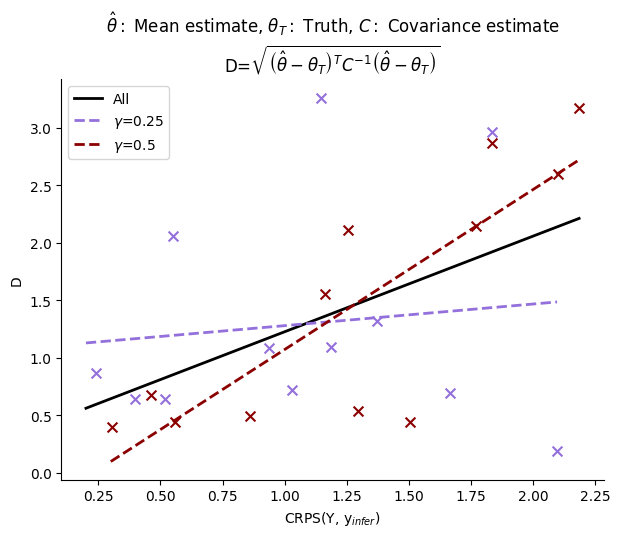

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(7, 5.2), sharex=False, sharey=False)

x, ylin = lin_reg(distance_df.distance_obs, distance_df.distance_estimate)
ax.plot(x, ylin, color="k", linestyle="-", label="All", lw=2)

colors = ["mediumpurple", "darkred"]

for idx_g, gamma in enumerate(distance_df.gamma.unique()):
    d_df = distance_df[distance_df.gamma==gamma]
    ax.scatter(d_df.distance_obs, d_df.distance_estimate, color=colors[idx_g], marker="x", s=50)
    x, ylin = lin_reg(d_df.distance_obs, d_df.distance_estimate)
    ax.plot(x, ylin, color=colors[idx_g], label=rf"$\gamma$={gamma}", lw=2, ls="--")

ax.set_title(r"$\hat{\theta}:$ Mean estimate, $\theta_T:$ Truth, $C:$ Covariance estimate"+"\n"+
            r"D=$\sqrt{\left(\hat{\theta}-\theta_T\right)^TC^{-1}\left(\hat{{\theta}}-\theta_T\right)}$")
ax.set_xlabel(r"CRPS(Y, y$_{infer}$)")
ax.set_ylabel("D")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend()

fig.savefig(os.path.join(results2_dir, "synthetic_inferences", "abm", "large_search", "distance_estimate_vs_crpsObs.png"), dpi=300, bbox_inches="tight")